## Data Cleaning & Preparation

In [1]:
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from langdetect import detect

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper functions
def extract_numeric_rating(rating):
    if isinstance(rating, str):
        match = re.search(r'(\d+(\.\d+)?)', rating)
        if match:
            return float(match.group(1))
    return rating

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

def process_reviews(hotel_name, source_folders, output_folder):
    all_reviews = []

    for source_folder in source_folders:
        files = [file for file in os.listdir(source_folder) if file.endswith('.csv')]
        print(f"\n\nFound {len(files)} files in {source_folder} for {hotel_name}")
        
        for file in files:
            if hotel_name in file:
                file_path = os.path.join(source_folder, file)
                reviews = pd.read_csv(file_path)
                print(f"\nProcessing file: {file_path} with {reviews.shape[0]} rows")
                
                if not all(col in reviews.columns for col in ['Review Content', 'Review Score', 'Review Time']):
                    print(f"Skipping file {file} due to missing required columns.")
                    continue
                
                reviews.dropna(subset=['Review Content', 'Review Score'], inplace=True)
                print(f"After dropping missing values: {reviews.shape[0]} rows")
                
                scaler = MinMaxScaler(feature_range=(0, 1))
                reviews['Review Score'] = scaler.fit_transform(reviews[['Review Score']])
                print(f"After normalizing ratings: {reviews.shape[0]} rows")
                
                reviews = reviews[reviews['Review Content'].apply(is_english)]
                print(f"After filtering non-English reviews: {reviews.shape[0]} rows")
                
                reviews.drop_duplicates(subset=['Review Content'], inplace=True)
                print(f"After removing duplicates: {reviews.shape[0]} rows")
                
                reviews['Review Content'] = reviews['Review Content'].apply(preprocess_text)
                print(f"After text preprocessing: {reviews.shape[0]} rows")
                
                all_reviews.append(reviews)

    if all_reviews:
        combined_reviews = pd.concat(all_reviews, ignore_index=True)
    else:
        combined_reviews = pd.DataFrame(columns=['Review Content', 'Review Score', 'Review Time'])
    
    print(f"Total combined reviews: {combined_reviews.shape[0]} rows")

    if combined_reviews.empty:
        print(f"No reviews available after preprocessing for hotel {hotel_name}.")
        return

    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(combined_reviews['Review Content'])
    sequences = tokenizer.texts_to_sequences(combined_reviews['Review Content'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    y_ground_truth = combined_reviews['Review Score']
    y_normalized = (y_ground_truth - y_ground_truth.min()) / (y_ground_truth.max() - y_ground_truth.min())
    
    print(f"Distribution of normalized scores for {hotel_name}: {np.histogram(y_normalized, bins=10)}")

    positive_threshold = 0.75
    negative_threshold = 0.25

    y_labels = np.zeros_like(y_normalized)
    y_labels[y_normalized >= positive_threshold] = 1
    y_labels[y_normalized <= negative_threshold] = -1
    y_labels[(y_normalized > negative_threshold) & (y_normalized < positive_threshold)] = 0

    print(f"y_labels distribution for {hotel_name}: {np.unique(y_labels, return_counts=True)}")

    x_train, x_test, y_train, y_test = train_test_split(padded_sequences, y_labels, test_size=0.3, random_state=42)

    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    np.savez_compressed(output_path, 
                        x_train=x_train, 
                        x_test=x_test, 
                        y_train=y_train, 
                        y_test=y_test, 
                        y_labels=y_labels,  
                        x_test_indices=np.arange(len(x_test)))

    print(f"x_train shape: {x_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_labels shape: {y_labels.shape}")

    

# Define source and output folders using relative paths
def main():
    base_input_path = os.path.join('..', 'raw data')
    base_output_path = os.path.join('..', 'datasets')

    sources = ['agoda_hotel_reviews', 'booking_hotel_reviews', 'klook_hotel_reviews', 'tripadvisor_hotel_reviews']
    hotels = [
        'bai_hotel_reviews_2022_2024',
        'dusit_thani_mactan_reviews_2022_2024',
        'fairfield_by_marriott_cebu_reviews_2022_2024',
        'jpark_island_resort_and_waterpark_reviews_2022_2024',
        'seda_ayala_center_cebu_reviews_2022_2024',
        'waterfront_hotel_and_casino_reviews_2022_2024'
    ]

    # Mapping hotel names to numbered output folder names
    output_folder_names = {
        'bai_hotel_reviews_2022_2024': '1_bai_hotel',
        'dusit_thani_mactan_reviews_2022_2024': '2_dusit_thani_mactan',
        'fairfield_by_marriott_cebu_reviews_2022_2024': '3_fairfield_by_marriott_cebu',
        'jpark_island_resort_and_waterpark_reviews_2022_2024': '4_jpark_island_resort_and_waterpark',
        'seda_ayala_center_cebu_reviews_2022_2024': '5_seda_ayala_center_cebu',
        'waterfront_hotel_and_casino_reviews_2022_2024': '6_waterfront_hotel_and_casino'
    }

    source_folders = [os.path.join(base_input_path, source) for source in sources]

    for hotel in hotels:
        hotel_name = hotel.replace('_reviews_2022_2024', '')
        output_folder = os.path.join(base_output_path, output_folder_names[hotel])
        print(f"Processing {hotel_name} reviews...")
        process_reviews(hotel_name, source_folders, output_folder)
        print(f"Finished processing {hotel_name} reviews.")

if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing bai_hotel reviews...


Found 6 files in ..\raw data\agoda_hotel_reviews for bai_hotel

Processing file: ..\raw data\agoda_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 1909 rows
After dropping missing values: 1909 rows
After normalizing ratings: 1909 rows
After filtering non-English reviews: 1768 rows
After removing duplicates: 1753 rows
After text preprocessing: 1753 rows


Found 6 files in ..\raw data\booking_hotel_reviews for bai_hotel

Processing file: ..\raw data\booking_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 682 rows
After dropping missing values: 682 rows
After normalizing ratings: 682 rows
After filtering non-English reviews: 661 rows
After removing duplicates: 656 rows
After text preprocessing: 656 rows


Found 6 files in ..\raw data\klook_hotel_reviews for bai_hotel

Processing file: ..\raw data\klook_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 114 rows
After dropping missing values: 114 rows
After normalizing ratings: 114 rows
After filteri

## EDA

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the base path for datasets
base_output_path = os.path.join('..', 'datasets')

# List of hotel folders and their corresponding names for the EDA plots
hotel_folders = {
    '1_bai_hotel': 'bai_hotel',
    '2_dusit_thani_mactan': 'dusit_thani_mactan',
    '3_fairfield_by_marriott_cebu': 'fairfield_by_marriott_cebu',
    '4_jpark_island_resort_and_waterpark': 'jpark_island_resort_and_waterpark',
    '5_seda_ayala_center_cebu': 'seda_ayala_center_cebu',
    '6_waterfront_hotel_and_casino': 'waterfront_hotel_and_casino'
}

for folder, hotel_name in hotel_folders.items():
    output_folder = os.path.join(base_output_path, folder)
    
    # Load the preprocessed data
    data_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    data = np.load(data_path)
    
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    # # For EDA purposes only
    # # Review lengths
    # review_lengths = [len(review) for review in x_train]
    # plt.hist(review_lengths, bins=50)
    # plt.title(f'{hotel_name} Review Lengths')
    # plt.xlabel('Review Length (in words)')
    # plt.ylabel('Frequency')
    # plt.show()
    
    # # Distribution of Ratings in Training Data
    # plt.hist(y_train, bins=10, edgecolor='k')
    # plt.title(f"{hotel_name} - Distribution of Ratings in Training Data")
    # plt.xlabel("Rating")
    # plt.ylabel("Frequency")
    # plt.show()
    
    # # Distribution of Sentiment Scores
    # plt.hist(y_train, bins=20, alpha=0.5, label='Training Data')
    # plt.hist(y_test, bins=20, alpha=0.5, label='Test Data')
    # plt.legend(loc='upper right')
    # plt.title(f'{hotel_name} - Distribution of Sentiment Scores')
    # plt.xlabel('Sentiment Score')
    # plt.ylabel('Frequency')
    # plt.show()

## Positive & Negative Counts
#### to test for overfitting or underfitting check

In [3]:
import numpy as np

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and count sentiment labels
def count_sentiments(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"
        data = np.load(data_path)

        y_labels = data['y_labels']  # Assuming y_labels contains sentiment labels

        positive_count = np.sum(y_labels == 1)
        negative_count = np.sum(y_labels == -1)
        neutral_count = np.sum(y_labels == 0)

        print(f"Hotel: {hotel_name}")
        print(f"Positive reviews: {positive_count}")
        print(f"Negative reviews: {negative_count}")
        print(f"Neutral reviews: {neutral_count}")
        print(f"Total reviews: {len(y_labels)}")
        print("-" * 50)

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Count and display sentiments for each hotel
for hotel in hotels:
    count_sentiments(hotel)

Hotel: bai_hotel
Positive reviews: 3477
Negative reviews: 81
Neutral reviews: 295
Total reviews: 3853
--------------------------------------------------
Hotel: dusit_thani_mactan
Positive reviews: 1396
Negative reviews: 118
Neutral reviews: 318
Total reviews: 1832
--------------------------------------------------
Hotel: fairfield_by_marriott_cebu
Positive reviews: 49
Negative reviews: 8
Neutral reviews: 7
Total reviews: 64
--------------------------------------------------
Hotel: jpark_island_resort_and_waterpark
Positive reviews: 403
Negative reviews: 29
Neutral reviews: 91
Total reviews: 523
--------------------------------------------------
Hotel: seda_ayala_center_cebu
Positive reviews: 1564
Negative reviews: 53
Neutral reviews: 267
Total reviews: 1884
--------------------------------------------------
Hotel: waterfront_hotel_and_casino
Positive reviews: 1062
Negative reviews: 91
Neutral reviews: 422
Total reviews: 1575
--------------------------------------------------


# General Sentiment Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(





Training the CNN-biLSTM model for Hotel bai_hotel...
Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9005 - loss: 0.2516 - val_accuracy: 0.9000 - val_loss: 0.3328
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.8924 - loss: -0.1011 - val_accuracy: 0.8111 - val_loss: 2.4287
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9012 - loss: -3.0561 - val_accuracy: 0.8704 - val_loss: 2.3733
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9163 - loss: -10.8845 - val_accuracy: 0.8519 - val_loss: 7.2353
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9313 - loss: -14.2815 - val_accuracy: 0.8926 - val_loss: 10.2878
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9293 - loss: -20.1143 - val_accuracy: 0.8444 - val_loss: 5.2634
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9189 - loss: -37.1626 - val_accuracy: 0.7741 - val_loss: 11.1924
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 

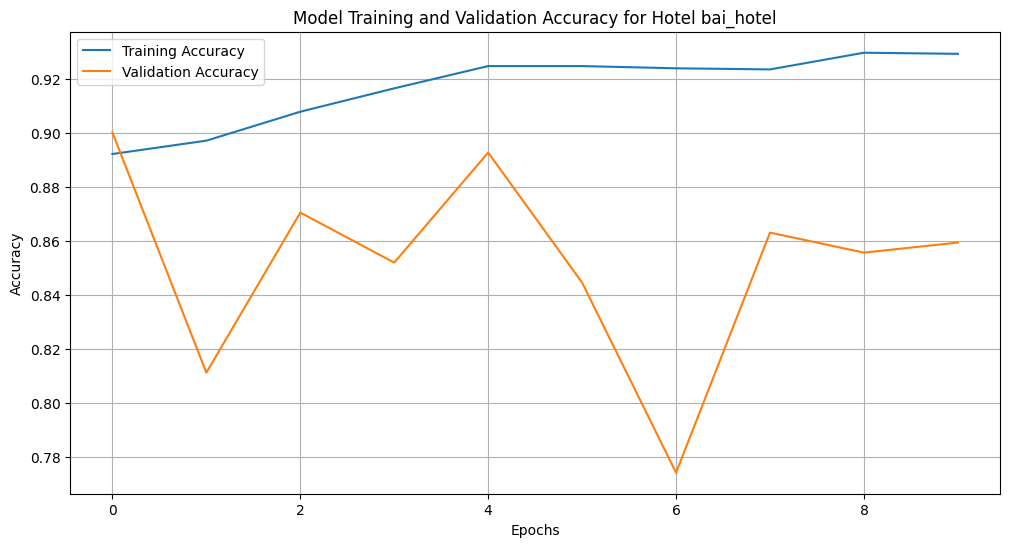

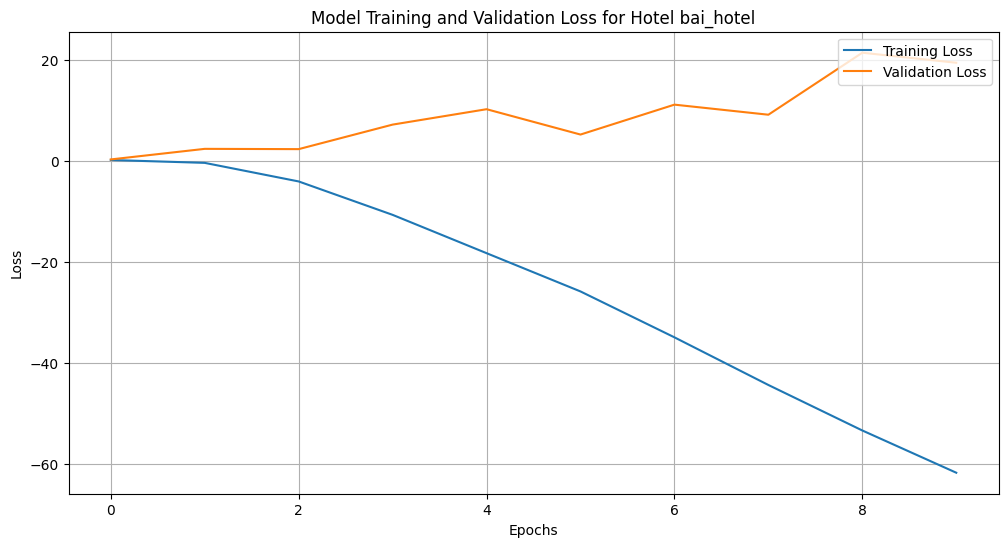

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8545 - loss: 42.0495
Test Loss for Hotel bai_hotel: 33.94118118286133
Test Accuracy for Hotel bai_hotel: 0.8780276775360107
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

Classification Report for Hotel bai_hotel:
              precision    recall  f1-score   support

    Negative       0.39      0.49      0.43       103
    Positive       0.95      0.93      0.94      1053

    accuracy                           0.89      1156
   macro avg       0.67      0.71      0.68      1156
weighted avg       0.90      0.89      0.89      1156



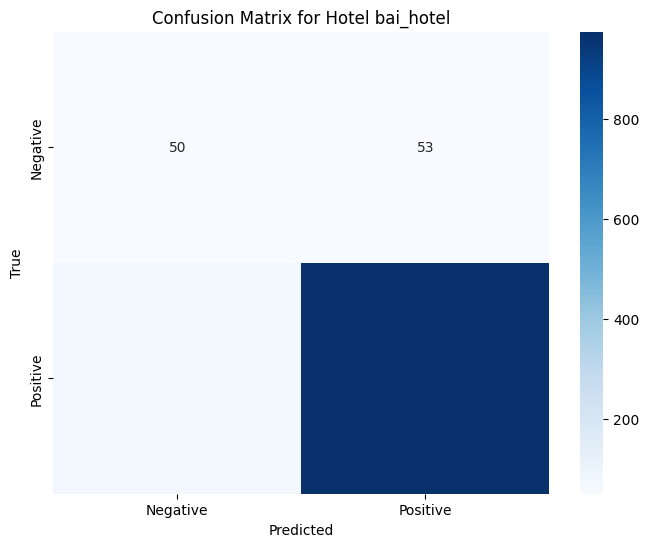

Mean Squared Error for Hotel bai_hotel: 0.1360397617121013
Predicted sentiment values for Hotel bai_hotel saved in ../predictions/1_bai_hotel



Training the CNN-biLSTM model for Hotel dusit_thani_mactan...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.6441 - loss: 0.4528 - val_accuracy: 0.7597 - val_loss: 0.5433
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7530 - loss: 0.3481 - val_accuracy: 0.7984 - val_loss: 0.2931
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8146 - loss: -0.9794 - val_accuracy: 0.8062 - val_loss: -0.5210
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8079 - loss: -13.2828 - val_accuracy: 0.5116 - val_loss: 15.6356
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7395 - loss: -22.4356 - val_accuracy: 0.7984 - val_loss: -6.0957
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8376 - loss: -50.0245 - val_accuracy: 0.7984 - val_loss: 18.7017
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8567 - loss: -57.4677 - val_accuracy: 0.7364 - val_loss: 6.4240
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8447 - loss: -84.0700 - val_accuracy: 0.7674

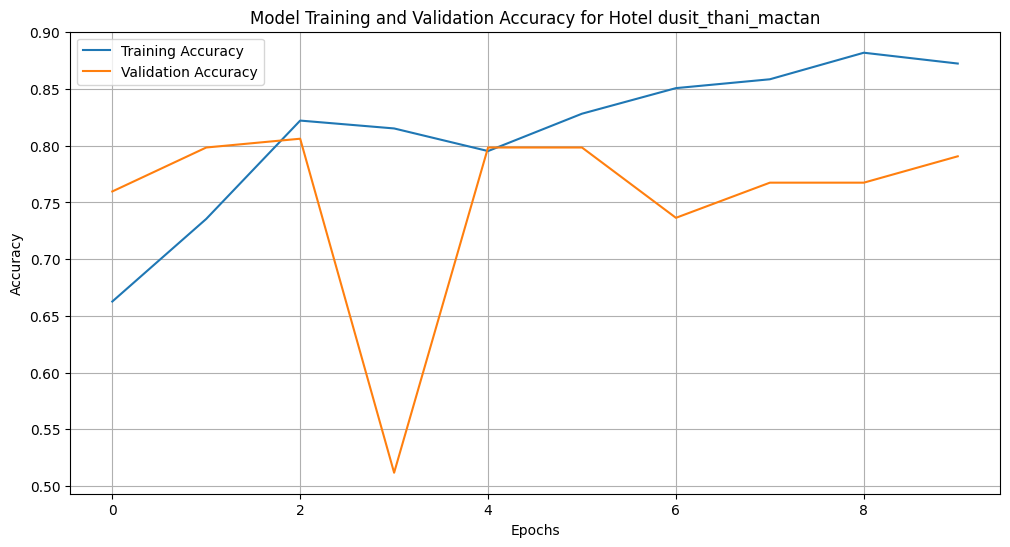

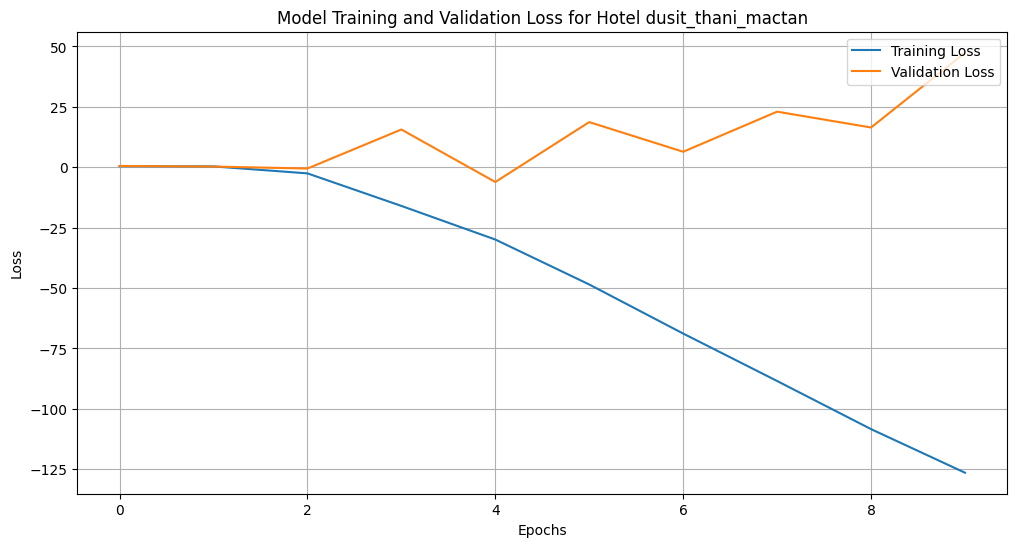

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7584 - loss: 40.5132
Test Loss for Hotel dusit_thani_mactan: 32.69145202636719
Test Accuracy for Hotel dusit_thani_mactan: 0.7309091091156006
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

Classification Report for Hotel dusit_thani_mactan:
              precision    recall  f1-score   support

    Negative       0.52      0.70      0.60       123
    Positive       0.90      0.82      0.86       427

    accuracy                           0.79       550
   macro avg       0.71      0.76      0.73       550
weighted avg       0.82      0.79      0.80       550



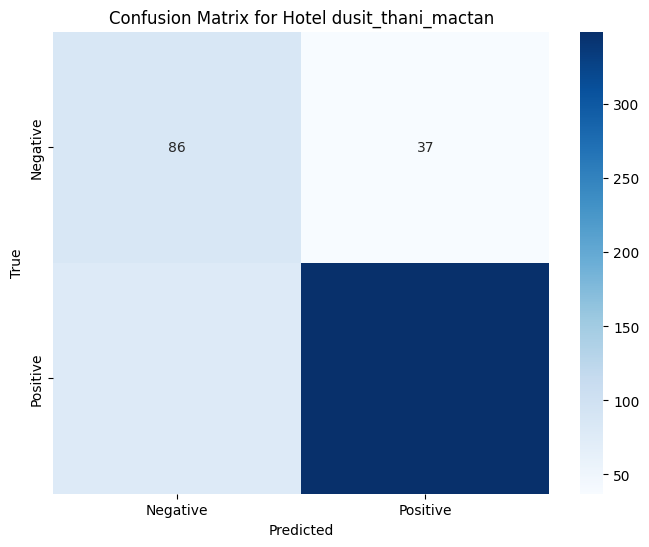

Mean Squared Error for Hotel dusit_thani_mactan: 0.29731125209019377
Predicted sentiment values for Hotel dusit_thani_mactan saved in ../predictions/2_dusit_thani_mactan



Training the CNN-biLSTM model for Hotel fairfield_by_marriott_cebu...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 713ms/step - accuracy: 0.1822 - loss: 0.5138 - val_accuracy: 0.6000 - val_loss: 0.6893
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6907 - loss: 0.4948 - val_accuracy: 0.6000 - val_loss: 0.6810
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7732 - loss: 0.4929 - val_accuracy: 0.6000 - val_loss: 0.6770
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7732 - loss: 0.4799 - val_accuracy: 0.6000 - val_loss: 0.6758
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5465 - loss: 0.4719 - val_accuracy: 0.8000 - val_loss: 0.6785
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4810 - loss: 0.4534 - val_accuracy: 0.8000 - val_loss: 0.6741
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5123 - loss: 0.4295 - val_accuracy: 0.8000 - val_loss: 0.6602
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5085 - loss: 0.4130 - val_accuracy: 0.8000 - val_loss: 0.6457
Epoch 9/10

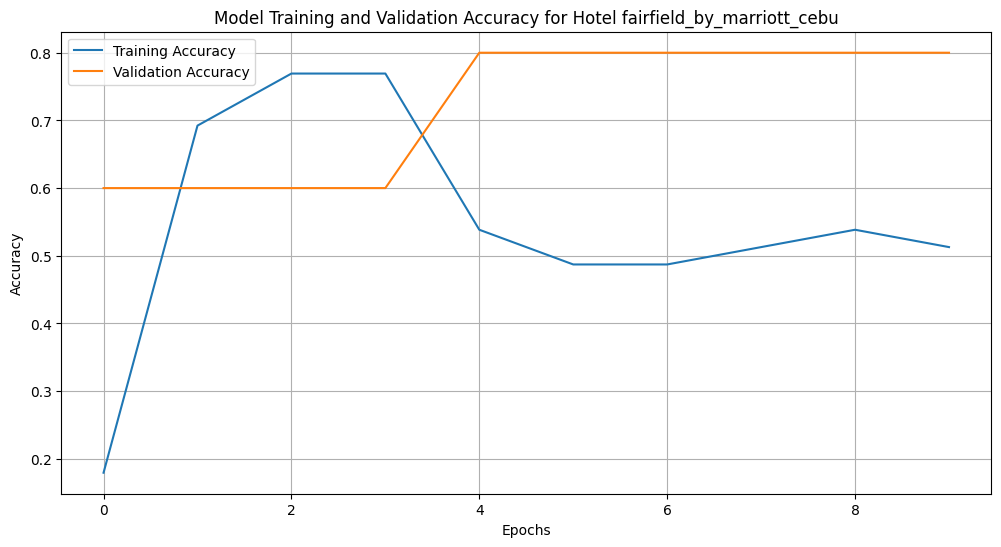

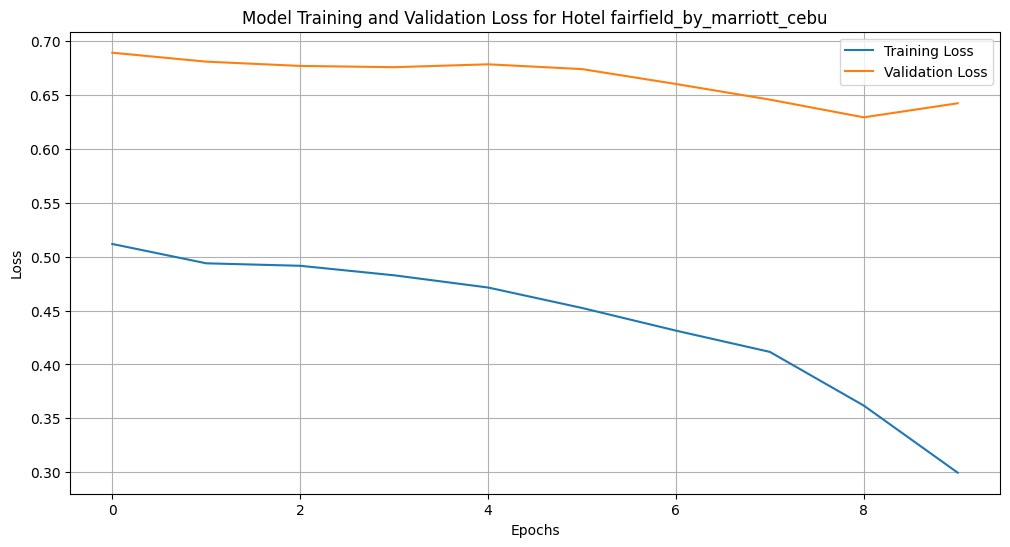

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3500 - loss: 1.0865
Test Loss for Hotel fairfield_by_marriott_cebu: 1.0865497589111328
Test Accuracy for Hotel fairfield_by_marriott_cebu: 0.3499999940395355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step

Classification Report for Hotel fairfield_by_marriott_cebu:
              precision    recall  f1-score   support

    Negative       0.15      0.50      0.24         4
    Positive       0.71      0.31      0.43        16

    accuracy                           0.35        20
   macro avg       0.43      0.41      0.34        20
weighted avg       0.60      0.35      0.39        20



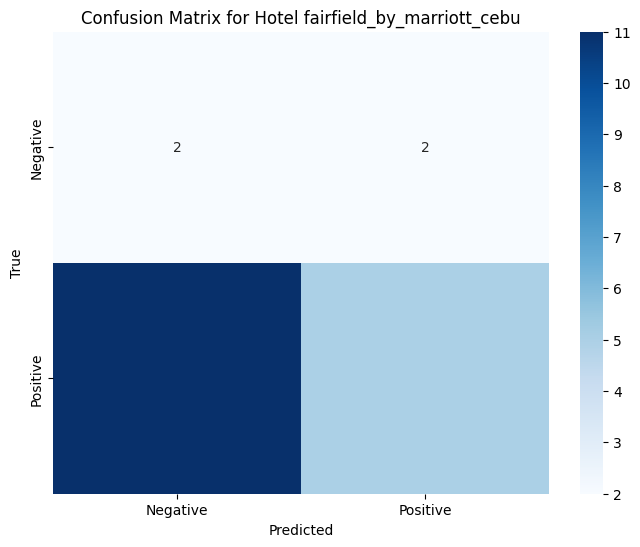

Mean Squared Error for Hotel fairfield_by_marriott_cebu: 0.5210477812192256
Predicted sentiment values for Hotel fairfield_by_marriott_cebu saved in ../predictions/3_fairfield_by_marriott_cebu



Training the CNN-biLSTM model for Hotel jpark_island_resort_and_waterpark...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.7390 - loss: 0.4215 - val_accuracy: 0.7027 - val_loss: 0.5460
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7927 - loss: 0.3289 - val_accuracy: 0.5676 - val_loss: 0.5089
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6983 - loss: 0.2363 - val_accuracy: 0.6486 - val_loss: 0.2128
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8199 - loss: -0.1970 - val_accuracy: 0.6757 - val_loss: -0.1441
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8553 - loss: -1.8296 - val_accuracy: 0.7297 - val_loss: -1.9069
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8096 - loss: -2.7774 - val_accuracy: 0.7027 - val_loss: 0.6071
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8489 - loss: -5.3510 - val_accuracy: 0.5135 - val_loss: -1.3269
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8708 - loss: -7.5791 - val_accuracy: 0.5135 - val

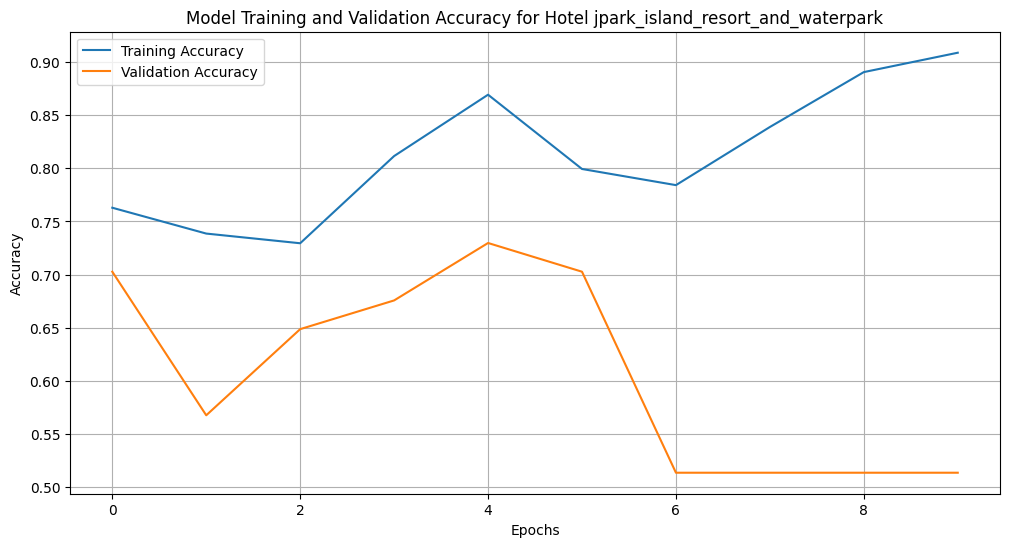

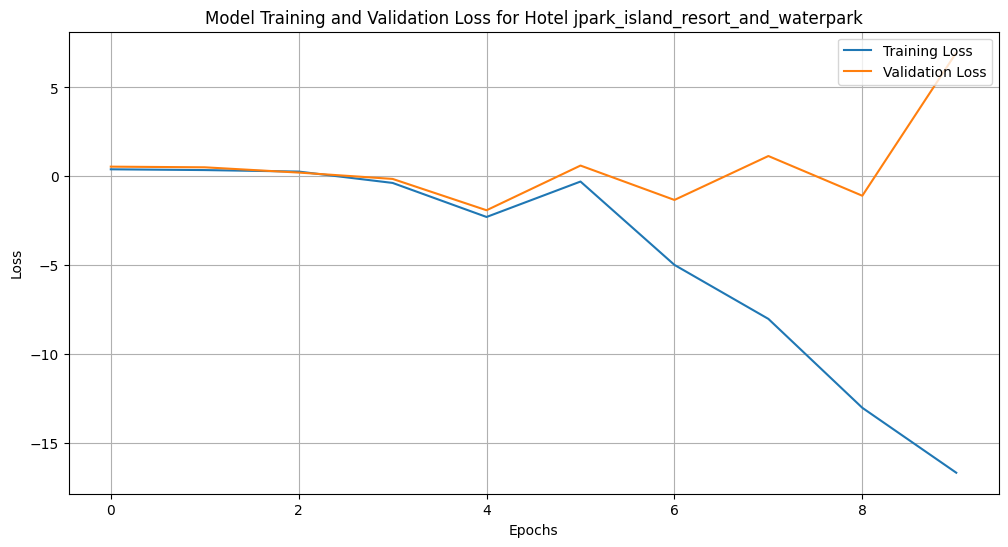

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6454 - loss: 11.1737
Test Loss for Hotel jpark_island_resort_and_waterpark: 13.857583999633789
Test Accuracy for Hotel jpark_island_resort_and_waterpark: 0.6433120965957642
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step WARNING:tensorflow:5 out of the last 24 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002030F3C5940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━

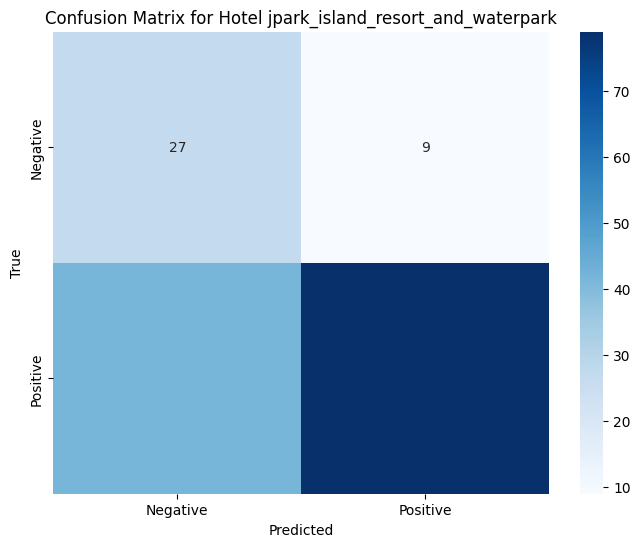

Mean Squared Error for Hotel jpark_island_resort_and_waterpark: 0.33323400535827485
Predicted sentiment values for Hotel jpark_island_resort_and_waterpark saved in ../predictions/4_jpark_island_resort_and_waterpark



Training the CNN-biLSTM model for Hotel seda_ayala_center_cebu...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.7675 - loss: 0.3524 - val_accuracy: 0.7879 - val_loss: 0.5793
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8449 - loss: 0.2817 - val_accuracy: 0.7652 - val_loss: 1.1577
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8958 - loss: -0.4643 - val_accuracy: 0.7727 - val_loss: 2.1439
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9172 - loss: -4.2192 - val_accuracy: 0.7576 - val_loss: 11.4516
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9143 - loss: -7.1505 - val_accuracy: 0.7045 - val_loss: 36.2606
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8953 - loss: -14.9208 - val_accuracy: 0.6818 - val_loss: 7.8091
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8922 - loss: -21.5656 - val_accuracy: 0.7424 - val_loss: 10.4925
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9116 - loss: -35.0849 - val_accuracy: 0.7273 - 

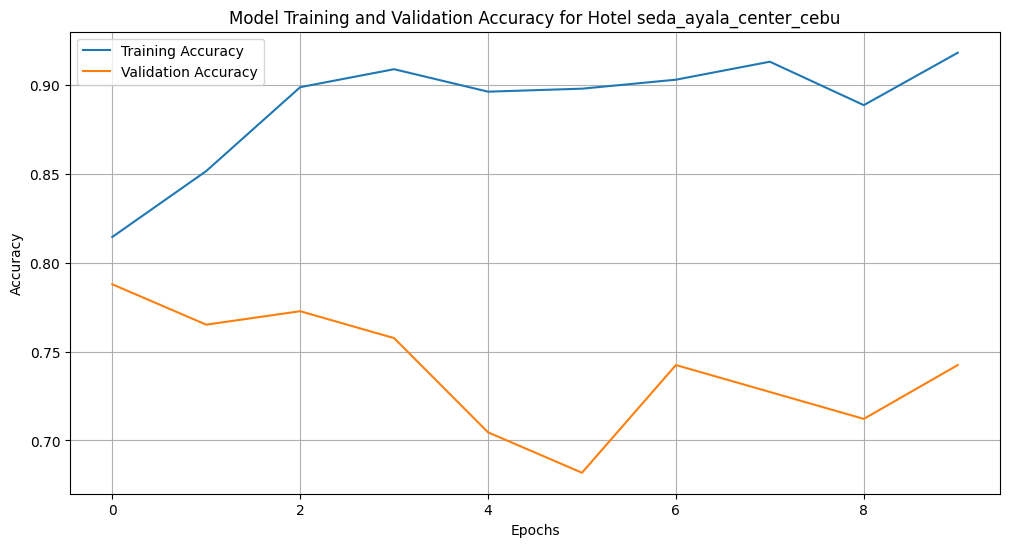

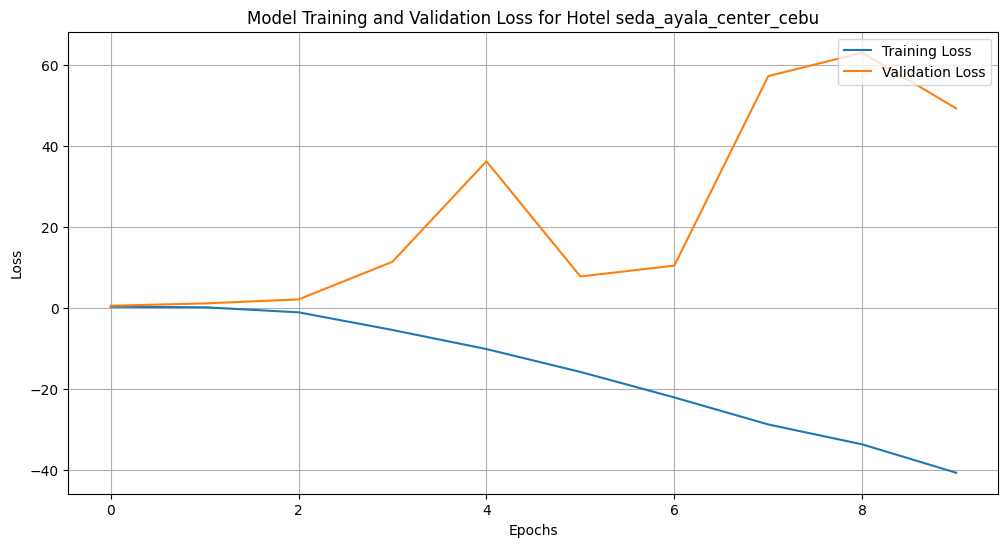

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8220 - loss: 19.9134
Test Loss for Hotel seda_ayala_center_cebu: 8.990776062011719
Test Accuracy for Hotel seda_ayala_center_cebu: 0.833922266960144
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

Classification Report for Hotel seda_ayala_center_cebu:
              precision    recall  f1-score   support

    Negative       0.56      0.40      0.47        87
    Positive       0.90      0.94      0.92       479

    accuracy                           0.86       566
   macro avg       0.73      0.67      0.69       566
weighted avg       0.85      0.86      0.85       566



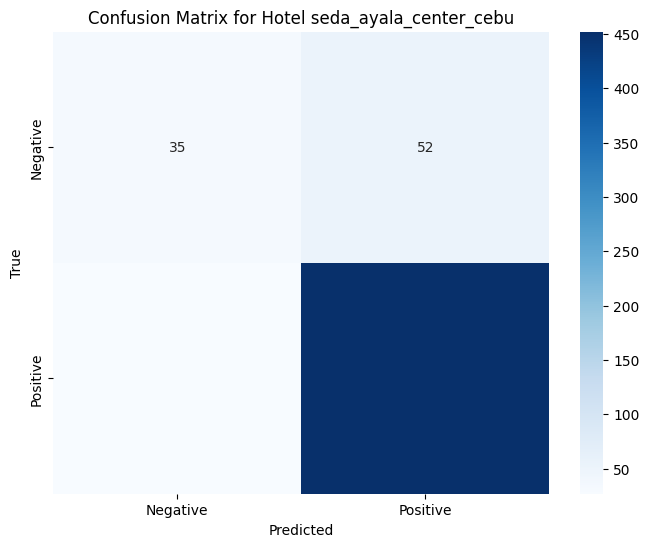

Mean Squared Error for Hotel seda_ayala_center_cebu: 0.19304486140466093
Predicted sentiment values for Hotel seda_ayala_center_cebu saved in ../predictions/5_seda_ayala_center_cebu



Training the CNN-biLSTM model for Hotel waterfront_hotel_and_casino...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.6571 - loss: 0.4822 - val_accuracy: 0.6937 - val_loss: 0.6435
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6917 - loss: 0.4354 - val_accuracy: 0.7568 - val_loss: 0.5421
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7866 - loss: -0.1066 - val_accuracy: 0.6396 - val_loss: 3.9749
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.7977 - loss: -3.5859 - val_accuracy: 0.7117 - val_loss: 7.1495
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8347 - loss: -11.6345 - val_accuracy: 0.4865 - val_loss: -0.0482
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8165 - loss: -22.5811 - val_accuracy: 0.7477 - val_loss: 3.8185
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8452 - loss: -24.0056 - val_accuracy: 0.7387 - val_loss: 44.8564
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8067 - loss: -47.7405 - val_accuracy: 0.7387 - 

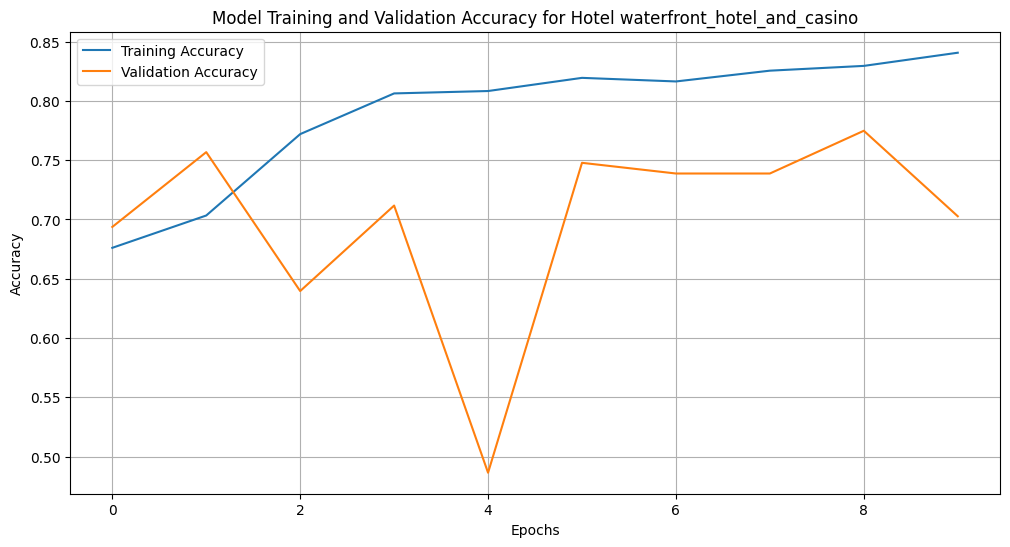

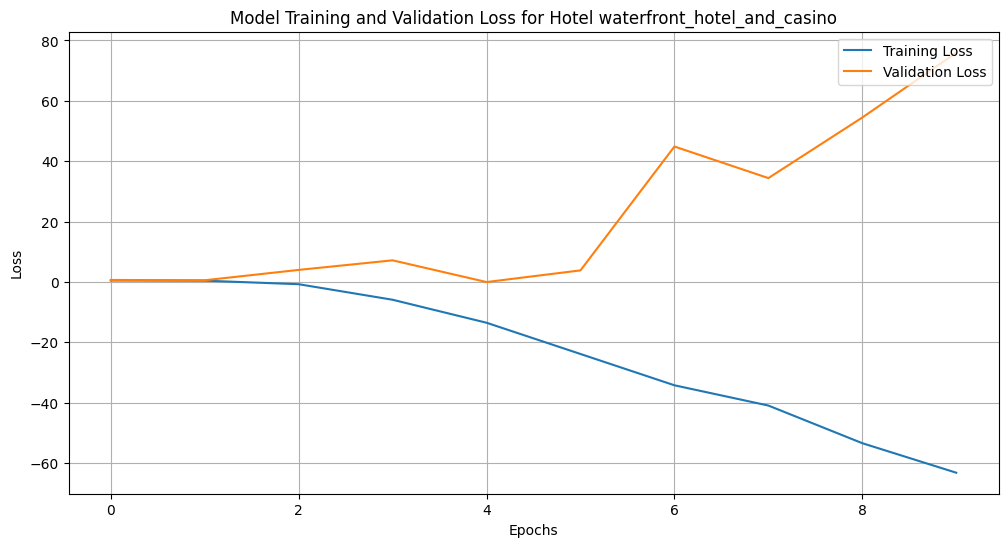

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6914 - loss: 10.7683
Test Loss for Hotel waterfront_hotel_and_casino: 39.09244155883789
Test Accuracy for Hotel waterfront_hotel_and_casino: 0.6871035695075989
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

Classification Report for Hotel waterfront_hotel_and_casino:
              precision    recall  f1-score   support

    Negative       0.68      0.58      0.63       171
    Positive       0.78      0.85      0.81       302

    accuracy                           0.75       473
   macro avg       0.73      0.72      0.72       473
weighted avg       0.75      0.75      0.75       473



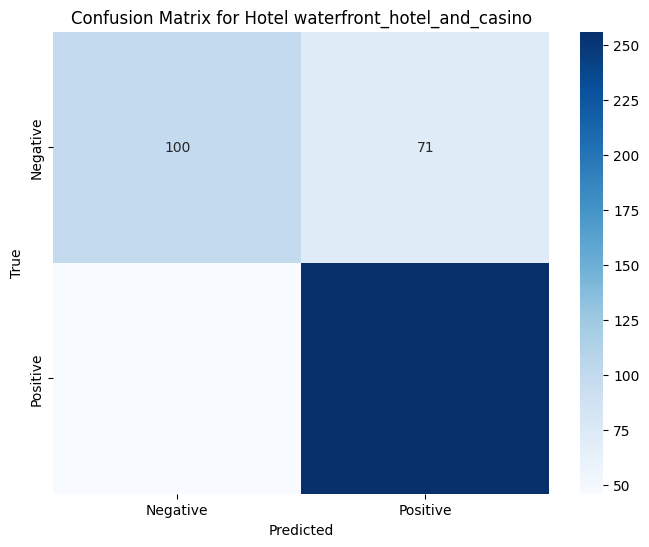

Mean Squared Error for Hotel waterfront_hotel_and_casino: 0.35954722961944463
Predicted sentiment values for Hotel waterfront_hotel_and_casino saved in ../predictions/6_waterfront_hotel_and_casino


In [4]:
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Ensure nltk resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Load preprocessed data for a single hotel
def load_data(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"
        data = np.load(data_path)
        return data
    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")
        return None

# Train and evaluate the model for a single hotel
def train_and_evaluate_model(x_train, x_test, y_train, y_test, label):
    try:
        input_text = Input(shape=(MAX_SEQUENCE_LENGTH,))
        embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
        conv1d = Conv1D(128, 5, activation='relu')(embedding)
        maxpool = MaxPooling1D(2)(conv1d)
        bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(maxpool)
        dropout = Dropout(0.5)(bi_lstm)
        flat = Flatten()(dropout)
        output = Dense(1, activation='sigmoid')(flat)
        model = Model(inputs=input_text, outputs=output)

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        print(f"\n\n\nTraining the CNN-biLSTM model for {label}...")
        
        # Calculate class weights
        class_weights = {0: len(y_train) / (2 * np.bincount(y_train == 0)[0]), 
                        1: len(y_train) / (2 * np.bincount(y_train == 1)[1])}

        # Train the model with class weights
        history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, class_weight=class_weights)

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Training and Validation Accuracy for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Training and Validation Loss for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        loss, accuracy = model.evaluate(x_test, y_test)
        print(f"Test Loss for {label}: {loss}")
        print(f"Test Accuracy for {label}: {accuracy}")

        y_pred_prob = model.predict(x_test)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Ensure y_test is binary for classification report
        y_test_binary = (y_test > 0.5).astype(int)

        print(f"\nClassification Report for {label}:")
        print(classification_report(y_test_binary, y_pred, target_names=['Negative', 'Positive']))

        conf_matrix = confusion_matrix(y_test_binary, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {label}')
        plt.show()

        # Evaluate regression metrics for continuous predictions
        mse = mean_squared_error(y_test, y_pred_prob)
        print(f"Mean Squared Error for {label}: {mse}")

        # Save and print the predicted sentiment values
        output_folder = f"../predictions/{hotel_folder_mapping[label.split()[1]]}"
        os.makedirs(output_folder, exist_ok=True)
        np.savez_compressed(os.path.join(output_folder, f"{label}_predictions.npz"), y_pred_prob=y_pred_prob)
        print(f"Predicted sentiment values for {label} saved in {output_folder}")

    except Exception as e:
        print(f"Error during training and evaluation for {label}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Perform sentiment analysis for each hotel
for hotel in hotels:
    data = load_data(hotel)
    if data is not None:
        x_train, x_test, y_train, y_test = data['x_train'], data['x_test'], data['y_train'], data['y_test']
        train_and_evaluate_model(x_train, x_test, y_train, y_test, f'Hotel {hotel}')
    else:
        print(f"Skipping sentiment analysis for {hotel} due to data loading error.")

        
###! GENERAL ANALYSIS OF RESULTS: 
# ! 1. potential overfitting : the imbalance is likely causing the model to be biased towards predicting the positive class
# ! 2. the model correctly identifies the positive samples almost all the time but struggles significantly with the negative samples
# ! 3. class imbalance is a significant issue in the dataset, and the model is not able to generalize well to the negative class

###* Addressing Class Imbalance
# * 1. oversampling the minority class (negative reviews) using techniques like SMOTE
# * 2. undersampling the majority class (positive reviews)
# * 3. using class weights during training to penalize misclassifications in the minority class
# * 4. using a different evaluation metric like F1-score or AUC-ROC that is less sensitive to class imbalance

## Loading of predicted values

In [5]:
import numpy as np
import os

# List of hotels and their respective folders
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and print predicted values
def load_and_print_predictions(hotel_name):
    folder_name = hotel_folder_mapping[hotel_name]
    prediction_path = f"../predictions/{folder_name}/Hotel {hotel_name}_predictions.npz"
    
    try:
        data = np.load(prediction_path)
        y_pred_prob = data['y_pred_prob']
        print(f"Predicted sentiment values for {hotel_name}:\n{y_pred_prob}")
    except Exception as e:
        print(f"Error loading predictions for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Load and print predictions for each hotel
for hotel in hotels:
    load_and_print_predictions(hotel)
    
#* NOTE: these are the predicted sentiment value of EACH review

Predicted sentiment values for bai_hotel:
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Predicted sentiment values for dusit_thani_mactan:
[[1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.51447126e-29]
 [3.58199532e-06]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99699771e-01]
 [0.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [0.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [0.00000000e+00]
 [9.99992251e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.50707477e-17]
 [1.00000000e+00]
 [1.00000000e+00]
 [7.56103635e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99999285e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 

# Aspect-based Sentiment Analysis

In [6]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200

# Load Aspect-Based Dataset from multiple CSV files
aspect_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\aspect-based\*.csv"
all_files = glob.glob(aspect_path)

# Initial empty DataFrame
aspect_data = pd.DataFrame()

# Load and unify all CSV files
for file in all_files:
    df = pd.read_csv(file)
    # Rename columns if necessary or handle missing 'Labels' column
    if 'Labels' not in df.columns:
        # Example: Assuming the column might be named 'Classification' instead
        if 'Classification' in df.columns:
            df.rename(columns={'Classification': 'Labels'}, inplace=True)
        else:
            df['Labels'] = None  # or df['Labels'] = 'default_value' if appropriate
    aspect_data = pd.concat([aspect_data, df], ignore_index=True)

# Check if 'Labels' column is properly set up
print(aspect_data.columns)

# Prepare Aspect Data
mlb = MultiLabelBinarizer()
aspect_data['Labels'] = aspect_data['Labels'].fillna('')  # Handle None or missing labels
aspect_data['Labels'] = aspect_data['Labels'].apply(lambda x: x.split(':'))
labels = mlb.fit_transform(aspect_data['Labels'])

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(aspect_data['Opinion'])  # Assuming 'Opinion' column holds the text
sequences = tokenizer.texts_to_sequences(aspect_data['Opinion'])
aspect_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Split the aspect data
x_train_aspects, x_test_aspects, y_train_aspects, y_test_aspects = train_test_split(aspect_padded, labels, test_size=0.3, random_state=42)

# Define biLSTM model for Aspect-Based Analysis
input_aspect = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_aspect = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_aspect)
bi_lstm_aspect = Bidirectional(LSTM(64, return_sequences=False))(embedding_aspect)
output_aspect = Dense(len(mlb.classes_), activation='softmax')(bi_lstm_aspect)
aspect_model = Model(inputs=input_aspect, outputs=output_aspect)

# Compile and train aspect model
print("Training the Aspect-Based Analysis model...")
aspect_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aspect_history = aspect_model.fit(x_train_aspects, y_train_aspects, epochs=10, batch_size=32, validation_split=0.1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['accuracy'], label='Train Accuracy')
plt.plot(aspect_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['loss'], label='Train Loss')
plt.plot(aspect_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RangeIndex(start=0, stop=0, step=1)


KeyError: 'Labels'

## KDE for each hotel

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


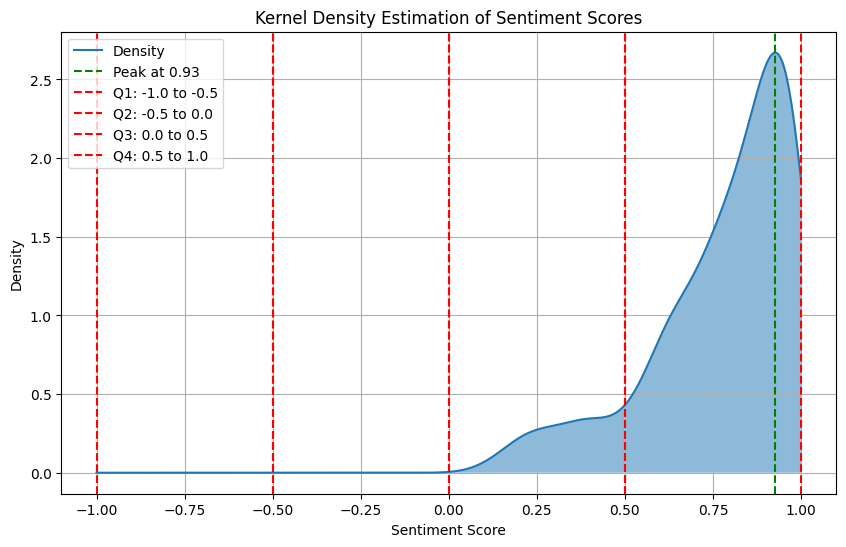

Peak value: 0.93
Quartiles: [(-1.0, -0.5), (-0.5, 0.0), (0.0, 0.5), (0.5, 1.0)]


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Model

y_pred = model.predict(x_test).flatten()  

# Define a function to plot KDE, identify peak, and fixed quartiles
def plot_kde_and_statistics(predictions, title="Sentiment Analysis Distribution"):
    plt.figure(figsize=(10, 6))
    kde = gaussian_kde(predictions)
    scores = np.linspace(-1, 1, 1000)  # fixed range for sentiment scores
    density = kde(scores)
    plt.plot(scores, density, label='Density')
    plt.fill_between(scores, density, alpha=0.5)

    # Identify peak
    peak = scores[np.argmax(density)]
    plt.axvline(x=peak, color='green', linestyle='--', label=f'Peak at {peak:.2f}')

    # Define fixed quartile ranges
    quartile_ranges = {
        'Q1': (-1.0, -0.5),
        'Q2': (-0.5, 0.0),
        'Q3': (0.0, 0.5),
        'Q4': (0.5, 1.0)
    }

    # Plot quartile ranges
    for label, (start, end) in quartile_ranges.items():
        plt.axvline(x=start, linestyle='--', color='red', label=f'{label}: {start} to {end}')
        plt.axvline(x=end, linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Peak value: {peak:.2f}")
    print(f"Quartiles: {list(quartile_ranges.values())}")

# Call the function to plot KDE and statistics
plot_kde_and_statistics(y_pred, title="Kernel Density Estimation of Sentiment Scores")

In [ ]:
import pandas as pd
import os

# Assuming 'aspect_predictions' is your predictions from the model
# and 'mlb.classes_' contains the class labels

# Predicting aspects using the trained model
aspect_predictions = aspect_model.predict(x_test)

# Convert aspect predictions to percentage likelihoods
aspect_likelihoods = np.mean(aspect_predictions, axis=0) * 100  # Average predictions and convert to percentage

# Map percentage likelihoods to corresponding labels
aspect_percentages = {label: percent for label, percent in zip(mlb.classes_, aspect_likelihoods)}
print("Aspect percentages:", aspect_percentages)

# Create a DataFrame to hold the labels and their corresponding percentage likelihoods
aspect_percentages_df = pd.DataFrame({
    'Aspect': mlb.classes_,
    'Percentage Likelihood': aspect_likelihoods
})

# Sort the DataFrame by likelihood in descending order for better readability
aspect_percentages_df = aspect_percentages_df.sort_values(by='Percentage Likelihood', ascending=False)

# # Specify the path where you want to save the CSV
# output_dir = '/datasets/aspect-based-results/'
# output_filename = 'waterfront_aspect_percentages.csv'

# # Check if the directory exists, if not, create it
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Build the complete file path
# file_path = os.path.join(output_dir, output_filename)

# # Save the DataFrame to a CSV file
# aspect_percentages_df.to_csv(file_path, index=False)

# Print the DataFrame
aspect_percentages_df


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Aspect percentages: {'': 0.0, 'Cleanliness': 1.8867376e-11, 'Comfort & Facilities': 29.187944, 'Food': 35.120018, 'Internet': 0.0, 'Location': 5.216267, 'Staff': 30.139652, 'Value for money': 0.33602843}


,Aspect,Percentage Likelihood
3,Food,3.512002e+01
6,Staff,3.013965e+01
2,Comfort & Facilities,2.918794e+01
5,Location,5.216267e+00
7,Value for money,3.360284e-01
1,Cleanliness,1.886738e-11
0,,0.000000e+00
4,Internet,0.000000e+00
